In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

import random
import numpy as np
import keras
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
## CD TO RIGHT DIRECTORY
# Add a shortcut to the 'DL Project' to your My Drive folder
%cd "/content/drive/My Drive/DL Project"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1Vhu7c9TtXf-INnjjgmUD94b4o35wSPWM/DL Project


In [ ]:
base_dir = 'code/data/oversampled_data'

In [ ]:
ls 'code/data/oversampled_data'

Albrecht_Dürer/  Frida_Kahlo/      Leonardo_da_Vinci/  Peter_Paul_Rubens/      Rembrandt/
Andy_Warhol/     Gustav_Klimt/     Michelangelo/       Pierre-Auguste_Renoir/  Salvador_Dali/
Caravaggio/      Jackson_Pollock/  Pablo_Picasso/      Piet_Mondrian/          Sandro_Botticelli/
Claude_Monet/    Jan_van_Eyck/     Paul_Gauguin/       Raphael/                Vincent_van_Gogh/


In [ ]:
artists_dict = {}
for name in list(os.listdir(base_dir)):
  if os.path.isdir(base_dir + "/" + name):
      curr_images = list(os.listdir(base_dir + "/" + name))
      for img in curr_images:
        if img.endswith(".jpg"):
          img_path = base_dir + "/" + name + "/" + img
          if name in artists_dict:
            artists_dict[name].append(img_path)
          else:
            artists_dict[name] = [img_path]

In [ ]:
train_1_images = []
train_2_images = []
dataset_labels = []
for author in artists_dict:
  author_imgs = artists_dict[author]
  for img in author_imgs:
    train_1_images.append(img)
    random_from_same_author = random.choice(author_imgs)
    train_2_images.append(random_from_same_author)
    dataset_labels.append(0)

    train_1_images.append(img)
    copy_artists_dict = artists_dict.copy()
    del copy_artists_dict[author]

    random_author = random.choice(list(copy_artists_dict.keys()))
    random_img = random.choice(copy_artists_dict[random_author])
    train_2_images.append(random_img)
    dataset_labels.append(1)

In [ ]:
total_count = 0
for artist in artists_dict:
  total_count += len(artists_dict[artist])
  print(len(artists_dict[artist]), artists_dict[artist])
print(total_count)

201 ['code/data/oversampled_data/Salvador_Dali/Salvador_Dali_5047.jpg', 'code/data/oversampled_data/Salvador_Dali/Salvador_Dali_7714.jpg', 'code/data/oversampled_data/Salvador_Dali/Salvador_Dali_6798.jpg', 'code/data/oversampled_data/Salvador_Dali/Salvador_Dali_8086.jpg', 'code/data/oversampled_data/Salvador_Dali/Salvador_Dali_1746.jpg', 'code/data/oversampled_data/Salvador_Dali/Salvador_Dali_7934.jpg', 'code/data/oversampled_data/Salvador_Dali/Salvador_Dali_9721.jpg', 'code/data/oversampled_data/Salvador_Dali/Salvador_Dali_7318.jpg', 'code/data/oversampled_data/Salvador_Dali/Salvador_Dali_7490.jpg', 'code/data/oversampled_data/Salvador_Dali/Salvador_Dali_7249.jpg', 'code/data/oversampled_data/Salvador_Dali/Salvador_Dali_3545.jpg', 'code/data/oversampled_data/Salvador_Dali/Salvador_Dali_9919.jpg', 'code/data/oversampled_data/Salvador_Dali/Salvador_Dali_5856.jpg', 'code/data/oversampled_data/Salvador_Dali/Salvador_Dali_2598.jpg', 'code/data/oversampled_data/Salvador_Dali/Salvador_Dali_8

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import random

# Assuming you have defined your hyperparameters
epochs = 10
batch_size = 16
margin = 1

# Assuming you have defined your embedding network architecture

# Assuming you have defined your contrastive loss function


# Create TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices((train_1_images, train_2_images, dataset_labels))

# Map preprocessing function to the dataset
def preprocess_image(image_path):
    # Implement your image preprocessing here
    # This function should take an image path and return the preprocessed image
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (105, 105))
    return image

# Map preprocessing function and pair creation to the dataset
dataset = dataset.map(lambda x1, x2, y: (preprocess_image(x1), preprocess_image(x2), y))
dataset = dataset.map(lambda x1, x2, y: ((x1, x2), y))  # Create pairs of images

# Split the dataset into train and validation
train_dataset = dataset.take(round(0.8 * len(dataset)))
val_dataset = dataset.skip(round(0.8 * len(dataset)))

# dataset = dataset.batch(batch_size)
# dataset = dataset.shuffle(buffer_size=len(train_1_images))  # Shuffle the dataset
# dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)  # Prefetch for performance optimization



In [ ]:
# Assuming you have defined your hyperparameters
epochs = 10
batch_size = 16
margin = 1

In [ ]:
def create_embedding_network():
    input = layers.Input((105, 105, 3))
    x = layers.Conv2D(32, (3, 3), activation='relu')(input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    output = layers.Flatten()(x)
    return Model(input, output)

def create_siamese_network(embedding_network):
    input_1 = layers.Input((105, 105, 3))
    input_2 = layers.Input((105, 105, 3))
    tower_1 = embedding_network(input_1)
    tower_2 = embedding_network(input_2)
    merge_layer = layers.Lambda(euclidean_distance, output_shape=(1,))([tower_1, tower_2])
    normal_layer = layers.BatchNormalization()(merge_layer)
    output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
    return Model(inputs=[input_1, input_2], outputs=output_layer)

In [ ]:
def contrastive_loss(y_true, y_pred):
    y_true = tf.cast(y_true, y_pred.dtype)  # Cast y_true to the same dtype as y_pred
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - (y_pred), 0))
    return tf.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)

# Assuming you have defined your Euclidean distance function
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((train_1_images, train_2_images, dataset_labels))

In [ ]:
def preprocess_image(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (105, 105))
    return image


In [ ]:
dataset = dataset.map(lambda x1, x2, y: (preprocess_image(x1), preprocess_image(x2), y))
dataset = dataset.map(lambda x1, x2, y: ((x1, x2), y))

train_dataset = dataset.take(round(0.8 * len(dataset)))
val_dataset = dataset.skip(round(0.8 * len(dataset)))

In [ ]:
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size=len(train_1_images))
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=len(train_1_images))
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
embedding_network = create_embedding_network()
siamese_network = create_siamese_network(embedding_network)
siamese_network.compile(loss=contrastive_loss, optimizer="RMSprop", metrics=["accuracy"])

In [ ]:
history = siamese_network.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

test_loss, test_acc = siamese_network.evaluate(test_dataset)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

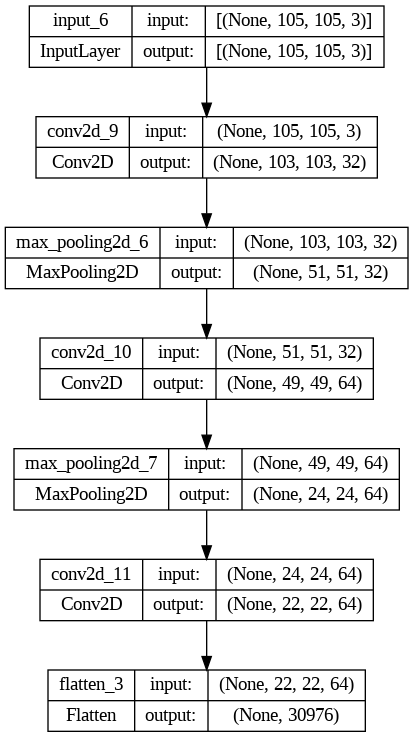

In [ ]:
from keras.utils import plot_model
plot_model(create_embedding_network(), to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# plot_model(siamese_network, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
siamese_network.save('code/SavedModels/SiameseClassifications/Oversampled')

In [ ]:
import matplotlib.pyplot as plt

# Summarize history for accuracy
# plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

# Summarize history for loss
# plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()


In [ ]:
print("Number of batches in train_dataset:", len(train_dataset))
print("Number of batches in val_dataset:", len(val_dataset))

Number of batches in train_dataset: 505
Number of batches in val_dataset: 0


In [ ]:
# Paths to your two images
image_path1 = base_dir + '/Frida_Kahlo/Frida_Kahlo_1.jpg'
image_path2 = base_dir + '/Caravaggio/Caravaggio_2.jpg'
print(image_path1)
print(image_path2)
# Load and preprocess the images
image1 = preprocess_image(image_path1)
image2 = preprocess_image(image_path2)

# Add a batch dimension
image1 = tf.expand_dims(image1, axis=0)
image2 = tf.expand_dims(image2, axis=0)

# Assuming 'siamese_network' is your loaded Siamese model
predictions = siamese_network([image1, image2])

print("Predictions:", predictions.numpy())



code/data/original_data/Frida_Kahlo/Frida_Kahlo_1.jpg
code/data/original_data/Caravaggio/Caravaggio_2.jpg
Predictions: [[0.8622455]]


In [ ]:
import re
def average_similarity(base_dir, ref_image_path, n):
    ref_image = preprocess_image(ref_image_path)
    ref_image = tf.expand_dims(ref_image, axis=0)  # Add batch dimension
    highest_avg_similarity = -1
    most_similar_subfolder = None

    for subfolder in os.listdir(base_dir):
        subfolder_path = os.path.join(base_dir, subfolder)
        if os.path.isdir(subfolder_path):
            image_files = [f for f in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, f))]
            if len(image_files) >= n:
                chosen_images = random.sample(image_files, n)
                similarities = []
                for image in chosen_images:
                    image_path = os.path.join(subfolder_path, image)
                    image = preprocess_image(image_path)
                    image = tf.expand_dims(image, axis=0)  # Add batch dimension
                    prediction = siamese_network([ref_image, image])  # Predict similarity
                    similarities.append(prediction.numpy()[0])

                avg_similarity = np.mean(similarities)
                # print(f"Average similarity for {subfolder}: {avg_similarity}")
                if avg_similarity > highest_avg_similarity:
                    highest_avg_similarity = avg_similarity
                    most_similar_subfolder = subfolder

    return most_similar_subfolder, highest_avg_similarity

def process_percentage_of_images(base_dir, image_list, percentage, n):
    num_images = int(len(image_list) * percentage / 100)
    selected_images = random.sample(image_list, num_images)
    print(len(selected_images))
    print(len(set(selected_images)))
    results = {}
    for real_img in selected_images:
        folder, score = average_similarity(base_dir, real_img, n)
        results[real_img] = (folder, score)

    accuracy_count = 0
    for img in results:
      print(img)
      match = re.match(r'/([^/]+)/[^/]+$', img)
      print(match)
      if match:
          result = match.group(0)
          print("Result: " + result)
          if result == results[img][0]:
            accuracy_count += 1

    return results, accuracy_count / len(list(results.keys()))

In [ ]:
ref_image_path = base_dir + '/Frida_Kahlo/Frida_Kahlo_1.jpg'
n = 1  # Number of random images to compare from each subfolder
most_similar_subfolder, similarity_score = average_similarity(base_dir, ref_image_path, n)
print(f"The subfolder with the highest average similarity is {most_similar_subfolder} with a score of {similarity_score}")


In [ ]:

results, acc_count = process_percentage_of_images(base_dir, train_1_images[0 : 1], 100, 2)
print(results)
for img, (folder, score) in results.items():
    print(f"Reference Image: {img} - Best Matching Folder: {folder} with a Score of {score}")
print(acc_count)